In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

class lumfuncs(object):
    def __init__(self, cosmo, z, lum, z_bins, n_lum_bins, survey_area):
        """ 
        Class for calculating luminosity functions
        
        Parameters
        ----------
        cosmo : astropy.cosmology
            The cosmology to use for calculations
        
        z : array
            The redshifts of the galaxies in the survey
        
        lum : array
            The luminosities of the galaxies in the survey
        
        z_bins : list
            Start and end point pairs of the bins for the luminosity function
            Example: [(0, 0.1), (0.1, 0.2), (0.2, 0.3)]
        
        n_lum_bins : int
            The number of luminosity bins to use
        
        survey_area : float
            The area of the survey in square degrees
        """
        self._cosmo = cosmo
        self._max_z = (lum - 17) / 1.4
        self._max_z[self._max_z > 5.714] = 5.714 # max redshift for the survey
        
        self._data = pd.DataFrame({'z': z, 'lum': lum, 'max_z': self._max_z}).sort_values('lum') # probably doesnt need sorting
        self._data = self._data[self._data['z'] <= self._data['max_z']] # drop sources that are "undetectable"
        self._z = self._data['z'].values
        self._lum = self._data['lum'].values
        self._z_bins = np.array(z_bins)
        
        _, self._lum_bin_edges = np.histogram(self._lum, bins=n_lum_bins)
        self._lum_bins = list(zip(self._lum_bin_edges, self._lum_bin_edges[1:]))
        self._lum_bins.append((self._lum_bin_edges[-1], float('inf')))
        self._survey_area = survey_area
    
    def _calc_volumes(self, z_bin_min, z_end):
        """ 
        Given a set of sources binned by redshift and binned by luminosity
        Step 1: Calculate the comoving distance of the sources and the distance to the end of the redshift bin
        Step 2: Calculate the volume of the shell between the sources and "the maximum redshift a source can be detected at the luminosity limit"
        Step 3: Correct the volume for the survey area
        """
        dmin = self._cosmo.comoving_distance(z_bin_min).value
        dmaxs = self._cosmo.comoving_distance(z_end).value
        
        vmin = 4/3 * np.pi * dmin ** 3
        vmaxs = 4/3 * np.pi * dmaxs ** 3

        volumes = vmaxs - vmin # if source_z is greater than z_end, volume will be negative
        
        corrected_area = self._survey_area / 41253
        volumes *= corrected_area
        return volumes        
    
    def bin_volumes(self):
        """ Calculate the volume of sources after binning in redshift and then binning in luminosity """
        all_volumes = []
        
        # Bin in redshift
        for z_min, z_max in self._z_bins:
            z_mask = (z_min <= self._z) & (self._z < z_max)
            bin_z_data = self._data[z_mask] # all sources within redshift bin
            
            redshift_volumes = []
            lum = bin_z_data['lum'].values
            
            # Bin in luminosity
            for lum_min, lum_max in self._lum_bins:
                lum_mask = (lum_min <= lum) & (lum < lum_max)
                bin_lum_data = bin_z_data[lum_mask] # all sources within luminosity bin at redshift bin
                
                # Calculate volumes
                max_zs = bin_lum_data['max_z'].values
                luminosity_volumes = self._calc_volumes(z_min, max_zs)
                redshift_volumes.append(luminosity_volumes)
                # print(np.sum(luminosity_volumes))
                
            all_volumes.append(redshift_volumes)
            # print('\n')
        return all_volumes
    
    def phi(self):
        """ Returns the luminosity function phi values for each redshift bin """
        delta_log_l = np.diff(self._lum_bins)[0]
        volumes = self.bin_volumes()
        
        phi_all = []
        for z_volume in volumes: # redshift bins
            phi_zbin = []
            for lum_volume in z_volume: # luminosity bins in redshift bin
                phi_lumbin = 1 / delta_log_l * np.sum(1 / lum_volume)
                phi_zbin.append(phi_lumbin)
            phi_all.append(np.ravel(phi_zbin))
        return phi_all   
    
    def plot_phi(self):
        """ Plots the luminosity function """
        phi = self.phi()
        for phi_z, (z_start, z_end) in zip(phi, self._z_bins):
            plt.plot(self._lum_bin_edges, phi_z, label=f'{z_start} $\leq$ z < {z_end}')
            # plt.scatter(self._lum_bin_edges, phi_z)
            plt.yscale('log')
            plt.xlabel(r'$M_{AB}$')
            plt.ylabel(r'$log(\phi$ [Mpc$^{-3}$ $M_{AB}^{-1}$])')
            plt.legend()
            plt.show()
            
    def plot_lum_hist(self):
        """ Plots the luminosity histogram """
        plt.hist(self._lum, bins=20)
        plt.xlabel(r'$M_{AB}$')
        plt.ylabel('Count')
        plt.show()

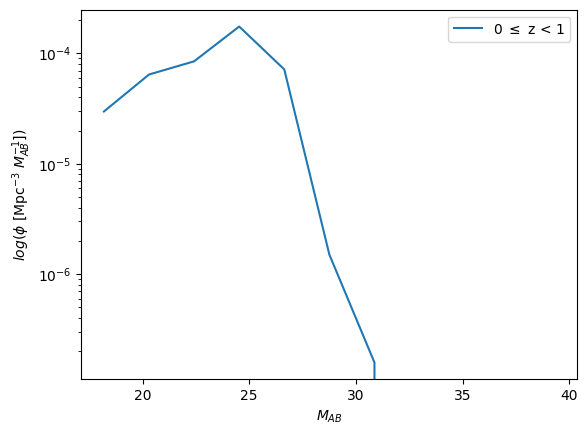

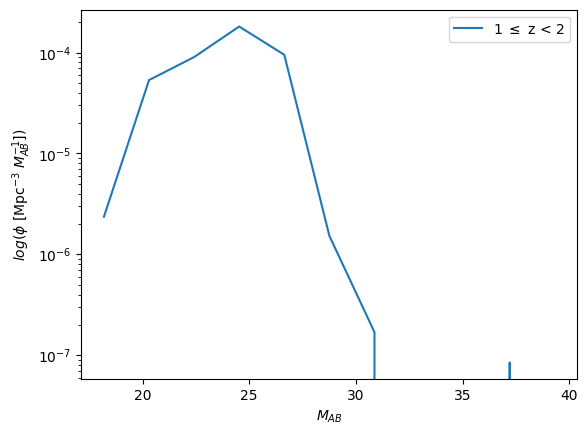

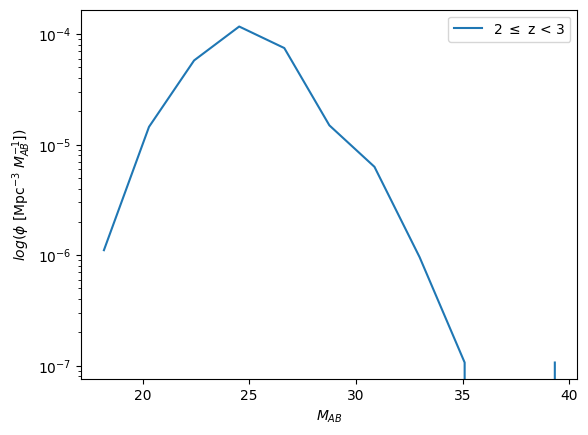

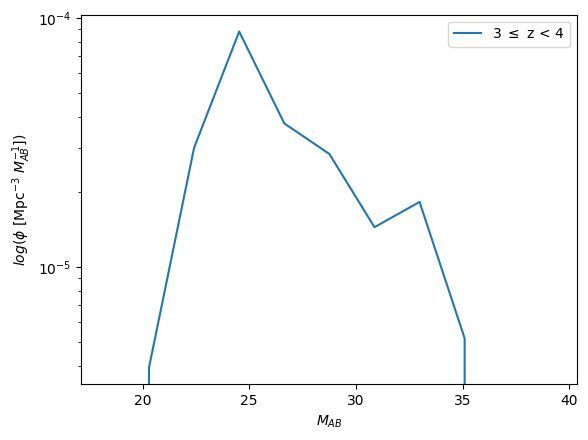

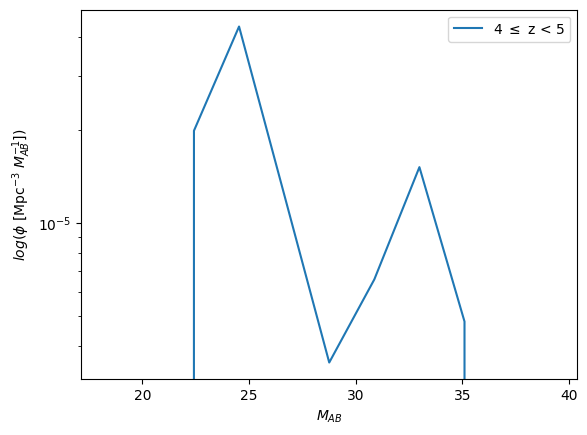

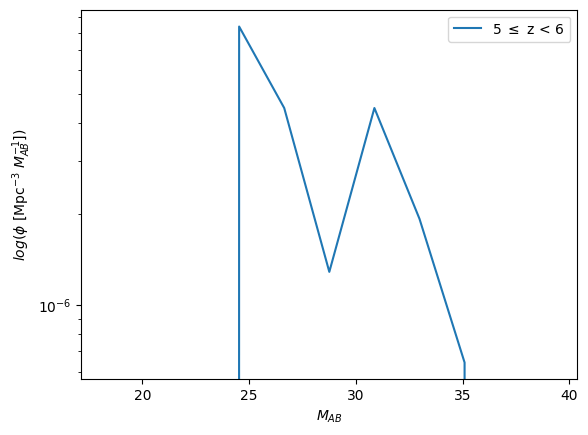

In [5]:
import pandas as pd
from astropy.cosmology import FlatLambdaCDM

# Read in CDFS main data
data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data) # 30,911 galaxies
df = df[df['Use'] == 1] # 13,299 galaxies

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
survey_area = 0.11 # square degrees
z = df['zpk'] # redshifts

dists = cosmo.luminosity_distance(z).value # luminosity distances
m_ab = 25 - 2.5*np.log10(df['FK']) # AB magnitude luminosities
lum = m_ab - 5 * np.log10(dists / 10)

z_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
n_lum_bins = 10 # number of luminosity bins

source = lumfuncs(cosmo, z, lum, z_bins, n_lum_bins, survey_area)
source.plot_phi()